# Exercise 09 - Semantic segmentation for rasterized LiDAR data

## Setup DevCube GPU

Before you can start, you have to find a GPU on the system that is not heavily used by other users. Otherwise you cannot initialize your neural network.


**Hint:** the command is **nvidia-smi**, just in case it is displayed above in two lines because of a line break.

As a result you get a summary of the GPUs available in the system, their current memory usage (in MiB for megabytes), and their current utilization (in %). There should be six or eight GPUs listed and these are numbered 0 to n-1 (n being the number of GPUs). The GPU numbers (ids) are quite at the beginning of each GPU section and their numbers increase from top to bottom by 1.

Find a GPU where the memory usage is low. For this purpose look at the memory usage, which looks something like '365MiB / 16125MiB'. The first value is the already used up memory and the second value is the total memory of the GPU. Look for a GPU where there is a large difference between the first and the second value.

**Remember the GPU id and write it in the next line instead of the character X.**

In [1]:
# Choose to the GPU number you want to use,
# otherwise you will get a Python error
# e.g. USE_GPU = 4
USE_GPU = 4 # YOUR_CHOICE

### Choose one GPU

**The following code is very important and must always be executed before using TensorFlow in the exercises, so that only one GPU is used and that it is set in a way that not all its memory is used at once. Otherwise, the other students will not be able to work with this GPU.**

The following program code imports the TensorFlow library for Deep Learning and outputs the version of the library.

Then, TensorFlow is configured to only see the one GPU whose number you wrote in the above cell (USE_GPU = X) instead of the X.

Finally, the GPU is set so that it does not immediately reserve all memory, but only uses more memory when needed. 

(The comments within the code cell explains a bit of what is happening if you are interested to better understand it. See also the documentation of TensorFlow for an explanation of the used methods.)

In [2]:
# Import TensorFlow 
import tensorflow as tf

# Print the installed TensorFlow version
print(f'TensorFlow version: {tf.__version__}\n')

# Get all GPU devices on this server
gpu_devices = tf.config.list_physical_devices('GPU')

# Print the name and the type of all GPU devices
print('Available GPU Devices:')
for gpu in gpu_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set only the GPU specified as USE_GPU to be visible
tf.config.set_visible_devices(gpu_devices[USE_GPU], 'GPU')

# Get all visible GPU  devices on this server
visible_devices = tf.config.get_visible_devices('GPU')

# Print the name and the type of all visible GPU devices
print('\nVisible GPU Devices:')
for gpu in visible_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set the visible device(s) to not allocate all available memory at once,
# but rather let the memory grow whenever needed
for gpu in visible_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow version: 2.3.0

Available GPU Devices:
  /physical_device:GPU:0 GPU
  /physical_device:GPU:1 GPU
  /physical_device:GPU:2 GPU
  /physical_device:GPU:3 GPU
  /physical_device:GPU:4 GPU
  /physical_device:GPU:5 GPU
  /physical_device:GPU:6 GPU
  /physical_device:GPU:7 GPU

Visible GPU Devices:
  /physical_device:GPU:4 GPU


In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import generator_segmentation_5cl

## Semantic segmentation for rasterized LiDAR data

Roof segmentation is an important processing stage in the 3D building reconstruction pipeline, e.g. from aerial 3D point clouds.

In this exercise you will learn how to build a Fully Convolutional Neural Network for semantic image segmentation.

### LEARNING OBJECTIVES

*  understand the particulatities of the semantic segmentation task (input, output dimensions, cost function)
* learn to build a convolutional encoder-architecture using various techniques for down-sampling and up-sampling
* undestand the metrics for semantic segmentation

You will train the model on a custom dataset preparde at our chair. It is a small subset from the dataset RoofNet3D. In order to be processable with 2D Convolutional architectures, the LIDAR point clouds representing a single roof type in the data, have been projected onto the horizontal plane. The resulting 2D images (height maps or rasters) have values that indicate the height of the interpolated z- values of the point falling in the respective cell. 

In the data, the classes are not equally represented, the Pyramid, Saddleback and Two-sided hip roof types, earch roof including 4, 4 and 2 roof segments respectively and the background as segmentation classes.

### Metrics for semnatic segmentation
The Intersection over Union (IoU) metric, also referred to as the Jaccard index, is a method to quantify the percent overlap between the target mask and our prediction output.  The IoU metric measures the number of pixels common between the target and prediction masks divided by the total number of pixels present across both masks.

<img src ='images/IOU.png'  width = "450" height = "120">


The function below generates the IOU of the prediction and ground truth masks. 

In [5]:
def compute_IOU(y_true, y_pred, nr_classes):
    """
      Computes IOU 

  Args:
    y_true (tensor) - ground truth label map
    y_pred (tensor) - predicted label ma
    """
    class_wise_iou = []
    smoothening_factor = 0.00001


    for i in range(nr_classes):
        intersection = np.sum((y_pred == i) * (y_true == i))
        y_true_area = np.sum((y_true == i))
        y_pred_area = np.sum((y_pred == i))
        combined_area = y_true_area + y_pred_area
    
        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        class_wise_iou.append(iou)


    return class_wise_iou

The images contain the height maps while the
annotations contain the pixel-wise label maps. Each label map has the shape (height, width , 1) with each point in this space denoting the corresponding pixel's class. Classes are in the range
[0, 5]
(i.e. 5 classes) and the pixel labels correspond to these classes:

### Load and explore the Dataset

Because the data has ben used to generate datasets for solving also classification tasks, the images are stored in directories according to the roof type, however this does not have an effect over your solution.

The dataset is already split in training, validation and testing. 

For loading the data you will use the custom generator function prvided in the file `generator_segmentation_5cl.py`. 

* The height and width of the input images and label maps (64p x 64p )
* The input images - height maps - have one channel.
* The label maps/segmentations masks have 5 channels a pixel having the value o in all the channels excepting in the channel corresponding to its class has the value one (one hot encoded labels).

In [6]:
class_names = ['background', 'segm_1','segm_2', 'segm_3', 'segm_4']

In [7]:
from pathlib import Path
ROOT = str(Path.home()) + r'/coursematerial/GIS/lidar_dataset_segmentation'

data_gen_training = generator_segmentation_5cl.training_gen(dir=ROOT)

In [8]:
img_list, gt_segmentation_mask_list = next(data_gen_training)

training


---- INPUT DIMENSIONS----
The batch size is: 32
The input image's height is: 64 pixel
The input image's width is: 64 pixel
An input image has 1 channels
 
---- OUTPUT (SEGMENTATION MASK) DIMENSIONS----
The height of the segmentation mask is: 64 pixel
The width of the segmentation mask is: 64 pixel
A segmentation mask has 5 channels
 


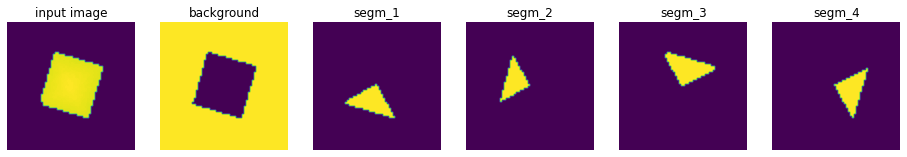

In [9]:
BATCH_SIZE = generator_segmentation_5cl.BATCH_SIZE
indx = np.random.randint(BATCH_SIZE)
raster_img= img_list[indx,:]
gt_segm_mask = gt_segmentation_mask_list[indx,:]

print('---- INPUT DIMENSIONS----') 
print(f"The batch size is: {BATCH_SIZE}")
print(f"The input image's height is: {raster_img.shape[0]} pixel")
print(f"The input image's width is: {raster_img.shape[1]} pixel" )
print(f'An input image has {raster_img.shape[-1]} channels')
print(' ')
print('---- OUTPUT (SEGMENTATION MASK) DIMENSIONS----') 
print(f"The height of the segmentation mask is: {gt_segm_mask.shape[0]} pixel")
print(f"The width of the segmentation mask is: {gt_segm_mask.shape[1]} pixel")
print(f'A segmentation mask has {gt_segm_mask.shape[-1]} channels')
print(' ')
fig_titles = ['input image'] + class_names
fig, axs = plt.subplots(1,6)
fig.set_figheight(7)
fig.set_figwidth(16)
axs[0].imshow(np.squeeze(raster_img) )

axs[0].set_title(fig_titles[0])
axs[0].axis('off')
for i in range(len(fig_titles)-1):
    axs[i+1].imshow(np.squeeze(gt_segm_mask[:,:,i]))
    axs[i+1].set_title(fig_titles[i+1])
    axs[i+1].axis('off')


## Building the model using the Functional API

In this exercise you will build a basic convolutional encoder - encoder decoder architecture.

The _decoder part_ resembles a typical classification architecture, where stacked Conv2D layers and downsampling operations (e.g. 2D pooling or Conv 2D with stride larger than 1) are used to extract hierarchical feature representations. 
However, since the goal of the **semantic segmentation task** is to predict **a category for each input pixel**, the output has _H x W x Nr_of_classes_ shape (as in contrast to the classification where the output dimenssion is the number of classes).
In order to gradually recover the spatial dimenssions (reduced due to pooling operations/ strides > 1) we build the _decoder part_.
To increase the spatial dimensions of a feature map  a we can use upsampling operations such as:
* [2D upsampling layer](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/layers/Conv2DTranspose) 
or
* [strided transposed convolution](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/layers/Conv2DTranspose). For the difference please between these operations please see the lecture notes.


Below you can see the encoder-decoder architecture to be implemented:

<img src ='images/encoder-decoder_architecture.png'  width = "750" height = "220">

In [10]:
INPUT_DIM = (generator_segmentation_5cl.IMAGE_HEIGHT,generator_segmentation_5cl.IMAGE_WIDTH,1)
OUTPUT_DIM = (generator_segmentation_5cl.IMAGE_HEIGHT,generator_segmentation_5cl.IMAGE_WIDTH,generator_segmentation_5cl.NUM_CLASSES)

### Implementation details:

1) firstly use the [INPUT](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/Input) class to instantiate the input tensor of `shape = INPUT_DIM`

2) use a  [Conv2D](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/layers/Conv2D) layer with 16 filters, kernel_size =3, and padding is 'same' that is applied to the inputs ; assign the layer/function to a variable $x$
- apply BatchNorm to the previous output
- apply [ELU](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/layers/ELU) layer to the previous output
- apply [MaxPool2D](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/layers/MaxPool2D) with pool_size = (2,2) to the previous output


3) use a Conv2D layer with 32 filters, kernel_size =3, and padding is 'same' (that is applied to the previous output) ; assign the layer/function to a variable  x 
- apply BatchNorm to the previous output
- apply ELU layer to the previous output
- apply MaxPool2D with pool_size = (2,2) to the previous output

4) use a Conv2D layer with 64 filters, kernel_size =3, and padding is 'same' (that is applied to the previous output) ; assign the layer/function to a variable  x 
- apply BatchNorm to the previous output
- apply ELU layer to the previous output


5) use a [Conv2DTranspose](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/layers/Conv2DTranspose) layer with 32 filters, kernel_size =3, strides =(2,2) and padding is 'same' (that is applied to the previous output) ; assign the layer/function to a variable x

- apply BatchNorm to the previous output
- apply ELU layer to the previous output

6) use a Conv2D layer with 32 filters, kernel_size =3, and padding is 'same' (that is applied to the previous output) ; assign the layer/function to a variable x

- apply BatchNorm to the previous output
- apply ELU layer to the previous output

7) use a [Conv2DTranspose](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/layers/Conv2DTranspose) layer with 16 filters, kernel_size =3, strides =(2,2) and padding is 'same' (that is applied to the previous output) ; assign the layer/function to a variable x

- apply BatchNorm to the previous output
- apply ELU layer to the previous output

8) use a Conv2D layer with 16 filters, kernel_size =3, and padding is 'same' (that is applied to the previous output) ; assign the layer/function to a variable x

- apply BatchNorm to the previous output
- apply ELU layer to the previous output

9) use a Conv2D layer  layer with 5 filters (= the number of segmentation classes) , kernel_size =1, strides =(1,1) and padding is 'same' (that is applied to the previous output), activation = 'softmax' ; assign the layer/function to a variable `output`.

In [12]:
import tensorflow as tf

In [13]:
from tensorflow.keras import models
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose,UpSampling2D, ELU, BatchNormalization, Dropout, concatenate, MaxPool2D

In [14]:
import generator_segmentation_5cl
bactch_size = generator_segmentation_5cl.BATCH_SIZE

In [15]:
NUM_CLASSES = generator_segmentation_5cl.NUM_CLASSES

In [16]:
inputs = Input(shape = INPUT_DIM)
x = Conv2D(16, (3, 3), strides=(1, 1), padding='same')(inputs)
x = BatchNormalization()(x)
x = ELU()(x)

x = MaxPool2D(pool_size=(2, 2))(x)

x = Conv2D(32, (3,3), strides=(1,1), padding="same")(x)
x = BatchNormalization()(x)
x = ELU()(x)

x = MaxPool2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3,3), strides=(1,1), padding="same")(x)
x = BatchNormalization()(x)
x = ELU()(x)

x = Conv2DTranspose(32, (3,3), strides=(2,2), padding="same")(x)
x = BatchNormalization()(x)
x = ELU()(x)
x = Conv2D(32, (3,3), strides=(1,1), padding="same")(x)
x = BatchNormalization()(x)
x = ELU()(x)
x = Conv2DTranspose(16, (3,3), strides=(2,2), padding="same")(x)
x = BatchNormalization()(x)
x = ELU()(x)
x = Conv2D(16, (3,3), strides=(1,1), padding="same")(x)
x = BatchNormalization()(x)
x = ELU()(x)
outputs = Conv2D(NUM_CLASSES, (1, 1), strides=(1, 1), padding='same', activation = 'softmax')(x)


model = models.Model(inputs,outputs)
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 16)        64        
_________________________________________________________________
elu (ELU)                    (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)       

In [17]:
from tensorflow.keras import optimizers
lr = 0.01
optimizer = optimizers.Adam()

#### Compile the model

- use as loss function categorical crossentropy
- Adam optimizer
- accuracy as metrics.

In [18]:
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])

In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor= 'val_loss', factor = 0.1, verbose= 1, min_delta= 0.00001)
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=5,
                           verbose=2,
                           mode='auto',
                           baseline=None)

### Train the model 
* on the data batches by calling the custom generator fuction
* pass in the callbacks list the callbacks to reduce learning rate and early stopping given above


In [20]:
data_gen_training = generator_segmentation_5cl.training_gen(dir=ROOT)
data_gen_valid = generator_segmentation_5cl.validation_data_gen(dir=ROOT)
data_gen_test = generator_segmentation_5cl.testing_gen_data_gen(dir=ROOT)

In [23]:
total_num_samples = 3000
epochs = 5
steps_per_epoch = int(total_num_samples/BATCH_SIZE)

In [24]:
history = model.fit(data_gen_training, batch_size=bactch_size, epochs=epochs,
     validation_data=data_gen_valid, steps_per_epoch = steps_per_epoch, validation_steps = 1)


Epoch 1/5
93/93 [==============================] - 4s 44ms/step - loss: 0.1834 - accuracy: 0.9406 - val_loss: 0.2194 - val_accuracy: 0.9182
Epoch 2/5
93/93 [==============================] - 4s 40ms/step - loss: 0.1739 - accuracy: 0.9429 - val_loss: 0.2079 - val_accuracy: 0.9397
Epoch 3/5
93/93 [==============================] - 3s 29ms/step - loss: 0.1779 - accuracy: 0.9400 - val_loss: 0.2906 - val_accuracy: 0.8929
Epoch 4/5
93/93 [==============================] - 3s 28ms/step - loss: 0.1701 - accuracy: 0.9429 - val_loss: 0.1881 - val_accuracy: 0.9391
Epoch 5/5
93/93 [==============================] - 3s 29ms/step - loss: 0.1677 - accuracy: 0.9435 - val_loss: 0.3177 - val_accuracy: 0.8739


In [25]:
if not os.path.exists(os.path.join('.', 'FIGURES')):
    os.mkdir(os.path.join('.','FIGURES'))

In [26]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])

    plt.legend(['train', 'validation'], loc='best', prop={'size': 10})

    plt.savefig(os.path.join('.', "FIGURES/{}.png".format(string)))
    plt.show()

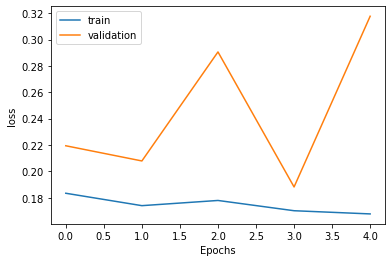

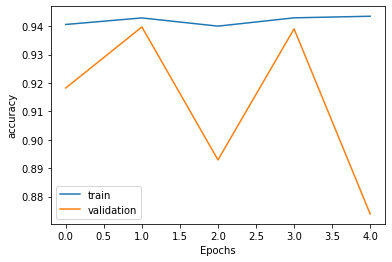

In [27]:
plot_graphs(history, 'loss')
plot_graphs(history, 'accuracy')

In [28]:
img_list, output_list_gt = next(data_gen_test)
# gt_mask_list = output_list_gt[0]
pred_masks_list = model.predict(img_list)

testing


In [29]:
# Get the maximum value in all channels
# Argmax axis= -1 because we have 5channels
# Argmax returns indices representing the location of the max
idx = pred_masks_list.argmax(axis=-1)
#Create an identical arrays to the previous dims to use for indexing
m,n,l = pred_masks_list.shape[:3]
I,J,L = np.ogrid[:m,:n,:l]
max_values = pred_masks_list[I,J,L,idx]
pred_masks_list = np.zeros(pred_masks_list.shape)
pred_masks_list[I,J,L,idx] = 1

In [30]:
indx = np.random.randint(BATCH_SIZE)
raster_img= img_list[indx,:]
gt_segm_mask = output_list_gt[indx,:]
pred_segm_mask = pred_masks_list[indx,:]

In [31]:
compute_IOU(gt_segm_mask, pred_segm_mask, 3)

[0.9071966381210549, 0.6779420707353817, 1.0]

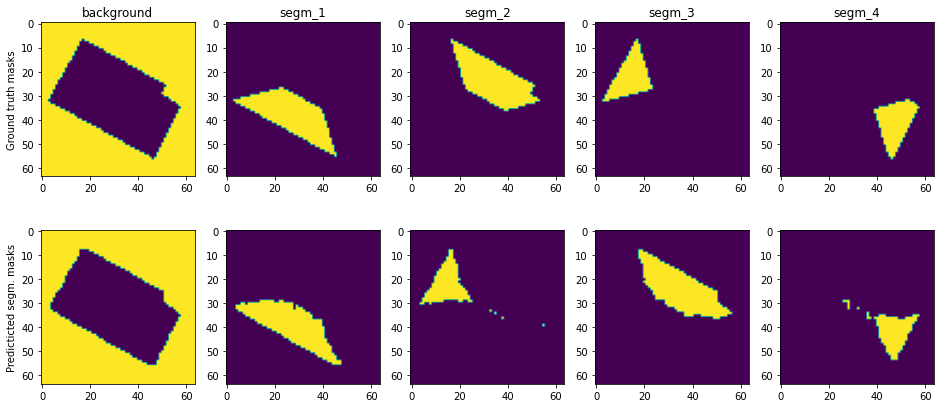

In [32]:
plt.close('all')
fig, axs = plt.subplots(2,5)
fig.set_figheight(7)
fig.set_figwidth(16)
# axs[0].imshow(np.squeeze(raster_img) )

# axs[0].set_title(fig_titles[0])
# axs[0].axis('off')
for i in range(len(fig_titles)-1):
    axs[0,i].imshow(np.squeeze(gt_segm_mask[:,:,i]))
    axs[0,i].set_title(fig_titles[i+1])
#     axs[0,i].axis('off')
    axs[0,0].set_ylabel('Ground truth masks')
    axs[1,i].imshow(np.squeeze(pred_segm_mask[:,:,i]))
    axs[1,0].set_ylabel('Predicticted segm. masks')
#     axs[1,i].axis('off')

#### Conclusions

When solving for the task of semantic segmentation, we predict the probability for each pixel belonging to a pre-defined set of classes
A typical Fully convolutional architecture includes:
-  an encoder part (down-sampling) - for extracting hierarchical feature representation (the spatial extent of the features maps is reduced)
- an decoder part (up-sampling) - for recovering the original size of the image


### Improving the baseline

You can use the very simple U-net type baseline by adding various features:

- experiment with strided convolutions (strides >2) instead max pool operations
- experiment with Upsampling 2D instead transpose convolutions
- increasing the capacity of the mode
- adding skip connections between layers of same size of the encoder and decoder respectivelly
- using a weighted cost function (the background pixels dominate, so the accuracy saturates in the very early stage of training)


### References and further readings :
Valentina Schmidt and Martin Kada (2019). Towards a Deep Learning Framework for 3D Building Reconstruction, 2nd International Workshop Point Cloud Processing, Stuttgart.

Andreas Wichmann, Amgad Agoub, Valentina Schmidt, Martin Kada (2019). RoofN3D: A Database for 3D Building Reconstruction with Deep Learning, Photogrammetric Engineering and Remote Sensing Journal

Olaf Ronneberger, Philipp Fischer, Thomas Brox. U-Net: Convolutional Networks for Biomedical Image Segmentation. Medical Image Computing and Computer-Assisted Intervention (MICCAI), Springer, LNCS, Vol.9351: 234--241, 2015, available at arXiv:1505.04597 [cs.CV]   
